# Bayesian Inference

## Sampling

In [2]:
# import warnings
# warnings.filterwarnings("ignore")
    
# Standard imports that we will need in the rest of the notebook.
import numpy as np
from numpy import inf
from scipy import stats

# Discrete distributions and sampling
from gym import Env, spaces, utils
from gym.utils import seeding

# Inverse reinforcement learning
from reinforce_learning import vi_rational
from inv_reinforce_learning_state_action import compute_s_a_visitations, vi_boltzmann, compute_D

# Plot
import matplotlib.pyplot as plt

# Data processing
import arviz as az

# Bayesian inference
import pymc3 as pm
import theano.tensor as tt
from theano.compile.ops import as_op

# Post-proc
from post_process import convert_to_dataset

print('Loading')

state_vis_freq = np.load('./data/state_vis_freq.npy')
prob_action_given_state = np.load('./data/prob_action_given_state.npy')
transition_proba = np.load('./data/transition_proba.npy')
state_feature_name = np.load('./data/state_feature_name.npy', allow_pickle=True)
action_feature_name = np.load('./data/action_feature_name.npy', allow_pickle=True)
state_feature = np.load('./data/state_feature.npy')
action_feature = np.load('./data/action_feature.npy')
initial_state_dist = np.load('./data/initial_state_dist.npy')

from environment import MDP, Environment

environment = Environment(state_feature_name, action_feature_name, 
                          state_feature, action_feature, transition_proba, initial_state_dist)
mdp = MDP(environment)

mdp.valid_sa = mdp.T.sum(axis=2)==1

print('Done')

Loading
Done


In [3]:
behavior_instances = np.load("data/generated_behavior_instances.npy")
n_data_per_base = 100
n_base_list = [1,10,100]
print('n_base_list: ', n_base_list)
horizon = len(behavior_instances[0])
state_feature_matrix = environment.state_feature_matrix
action_feature_matrix = environment.action_feature_matrix

mean_f_count_list = []
for n_base in n_base_list:
    # Computing E_tilde(P) from data
    E_P_tilde = []
    gamma = 1
    for i in range(n_base):
        trajectories = behavior_instances[n_data_per_base*i:n_data_per_base*(i+1)]
        sa_visit_count, P_0 = compute_s_a_visitations(mdp, gamma, trajectories)
        mean_s_visit_count = np.sum(sa_visit_count,1) / trajectories.shape[0]
        mean_a_visit_count = np.sum(sa_visit_count,0)[:-1] / trajectories.shape[0]
        mean_fs_count = np.array(np.dot(state_feature_matrix.T, mean_s_visit_count)).squeeze()
        mean_fa_count = np.array(np.dot(action_feature_matrix.T, mean_a_visit_count)).squeeze() 
        mean_f_count = np.append(mean_fs_count, mean_fa_count) # E_tilde(P) from data
        E_P_tilde.append(mean_f_count)
    mean_f_count_list.append(E_P_tilde)

# Constructing the model used for likelihood function
@as_op(itypes=[tt.dvector, tt.lscalar], otypes=[tt.dvector])
def mean_f_model(theta, i):
    h = horizon
    temperature = 1/5
    P_0_base = initial_state_dist #True P_0
    theta_state = (theta.reshape(-1,1))[:state_feature.shape[1],:]
    theta_action = (theta.reshape(-1,1))[state_feature.shape[1]:,:]
    r_s = np.squeeze(np.asarray(np.dot(state_feature_matrix, theta_state)))
    r_a = np.squeeze(np.asarray(np.dot(action_feature_matrix, theta_action)))
    V, Q, policy = vi_boltzmann(mdp, gamma, r_s, r_a, h, temperature)
    D_s = compute_D(mdp, gamma, policy, P_0_base, t_max=h)
    D_a = policy.T.dot(D_s)
    mean_fs_theta_count = np.array(np.dot(state_feature_matrix.T, D_s)).squeeze()
    mean_fa_theta_count = np.array(np.dot(action_feature_matrix.T, D_a)).squeeze()
    mean_f_theta_count = np.append(mean_fs_theta_count, mean_fa_theta_count)
    return mean_f_theta_count # E_P by following the model

if __name__ == '__main__':
    trace_list = []
    for i in range(len(n_base_list)):
        with pm.Model() as model:
            theta = pm.TruncatedNormal('theta', 0.5, 0.5, lower=0, upper=1, 
                                       shape=state_feature.shape[1]+action_feature.shape[1])
            mu = 0
            sigma = 3
#             mu = pm.Normal('mu', 0, 0.2, 
#                            shape=state_feature.shape[1]+action_feature.shape[1])
#             sigma = pm.InverseGamma('sigma', alpha=1, beta=1, 
#                                     shape=state_feature.shape[1]+action_feature.shape[1])
            mean = mean_f_model(theta, tt.cast(i, 'int64')) # mean is E_P
            y = pm.Normal('y', mu=mu+mean, sd=sigma, observed=mean_f_count_list[i])

            step = pm.Metropolis(vars=[theta])
            trace = pm.sample(draws=1000, cores=1, step=step)#, start={'theta':theta_init})
        trace_list.append(trace)
        np.save('trace_list_truncnormal_100.npy', convert_to_dataset(trace_list))

n_base_list:  [1, 10, 100]


Sequential sampling (2 chains in 1 job)
Metropolis: [theta]
  0%|          | 2/1500 [01:11<14:56:14, 35.90s/it]
Only one chain was sampled, this makes it impossible to run some convergence checks


KeyboardInterrupt: 

### theta plot

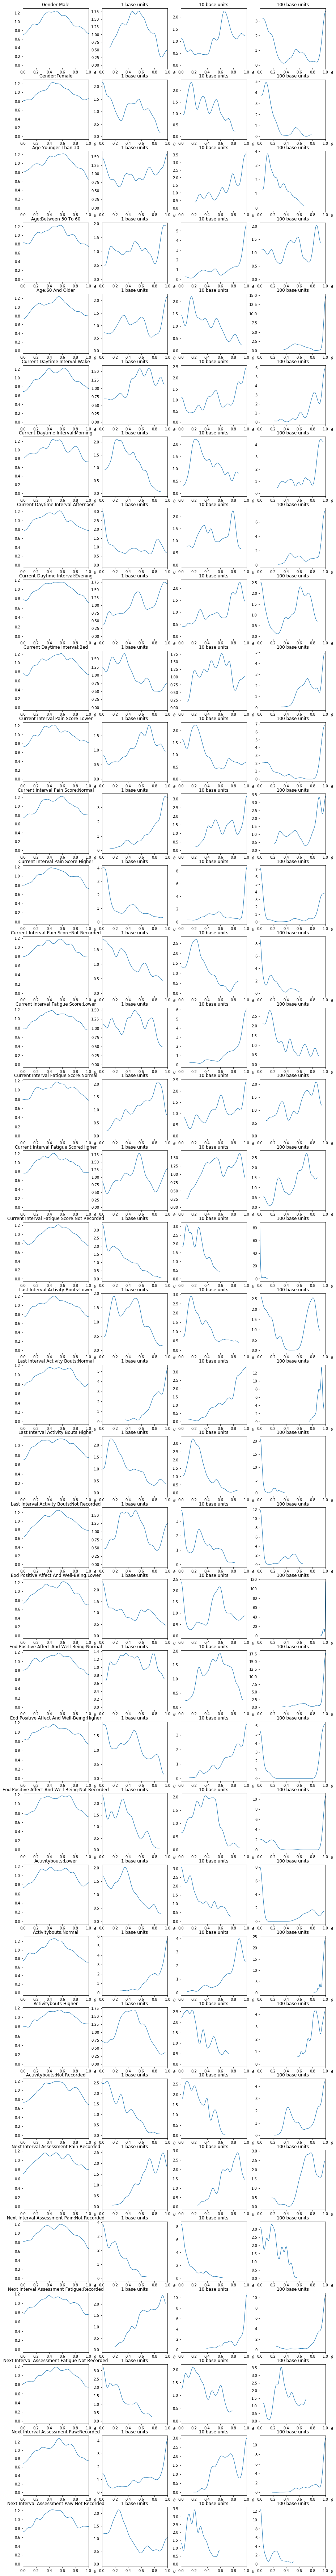

In [3]:
plt.figure(figsize=(15,130))
prior_sample = theta.random(size=4000)
for i in range(state_feature_matrix.shape[1]+action_feature_matrix.shape[1]):
    for j in range(len(n_base_list)+1):
        plt.subplot(state_feature_matrix.shape[1]+action_feature_matrix.shape[1], 
                    len(n_base_list)+1, i*(len(n_base_list)+1)+j+1)
        data = prior_sample[:,i] if j==0 else trace_list[j-1]['theta'][:,i]
        ax = pm.plots.kdeplot(data, textsize=10)
        ax.set_xlim(0, 1)
        if j==0:
            if i<state_feature_matrix.shape[1]:
                ax.set_title(environment.state_feature_names[i])
            else:
                ax.set_title(environment.action_feature_names[i-state_feature_matrix.shape[1]])
        else:
            ax.set_title('{} base units'.format(n_base_list[j-1]))
        ax.set_xlabel('$\\theta$', labelpad=-10, x=1.1)

### mu plot

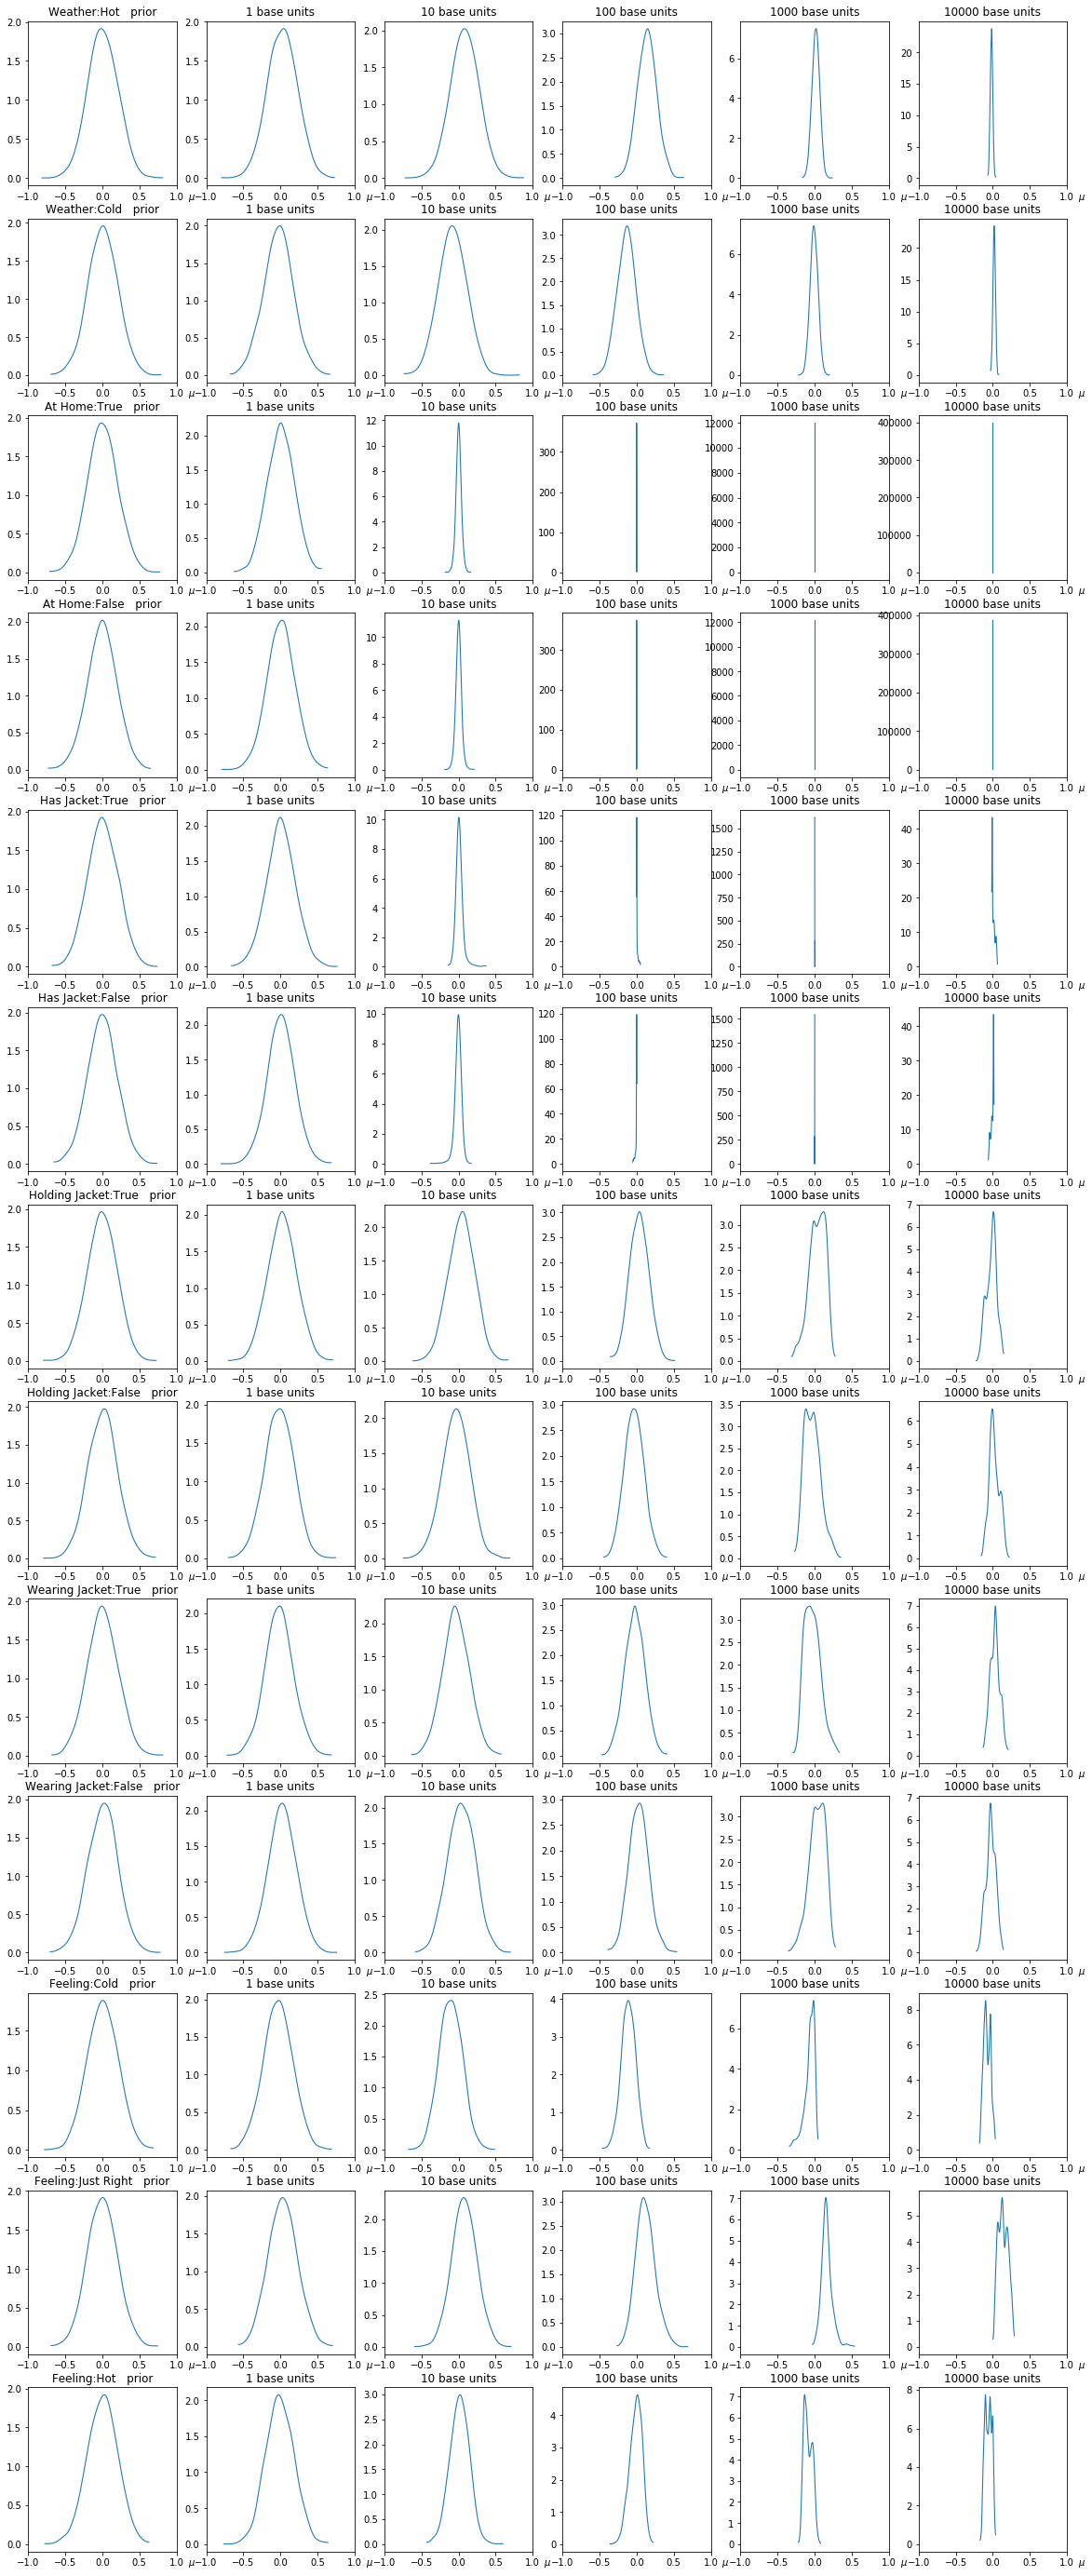

In [3]:
plt.figure(figsize=(15,130))
prior_sample = mu.random(size=4000)
for i in range(state_feature_matrix.shape[1]+action_feature_matrix.shape[1]):
    for j in range(len(n_base_list)+1):
        plt.subplot(state_feature_matrix.shape[1]+action_feature_matrix.shape[1], 
                    len(n_base_list)+1, i*(len(n_base_list)+1)+j+1)
        data = prior_sample[:,i] if j==0 else trace_list[j-1]['mu'][:,i]
        ax = pm.plots.kdeplot(data, textsize=10)
        ax.set_xlim(0, 1)
        if j==0:
            if i<state_feature_matrix.shape[1]:
                ax.set_title(environment.state_feature_names[i])
            else:
                ax.set_title(environment.action_feature_names[i-state_feature_matrix.shape[1]])
        else:
            ax.set_title('{} base units'.format(n_base_list[j-1]))
        ax.set_xlabel('$\\mu$', labelpad=-10, x=1.1)

### sigma plot

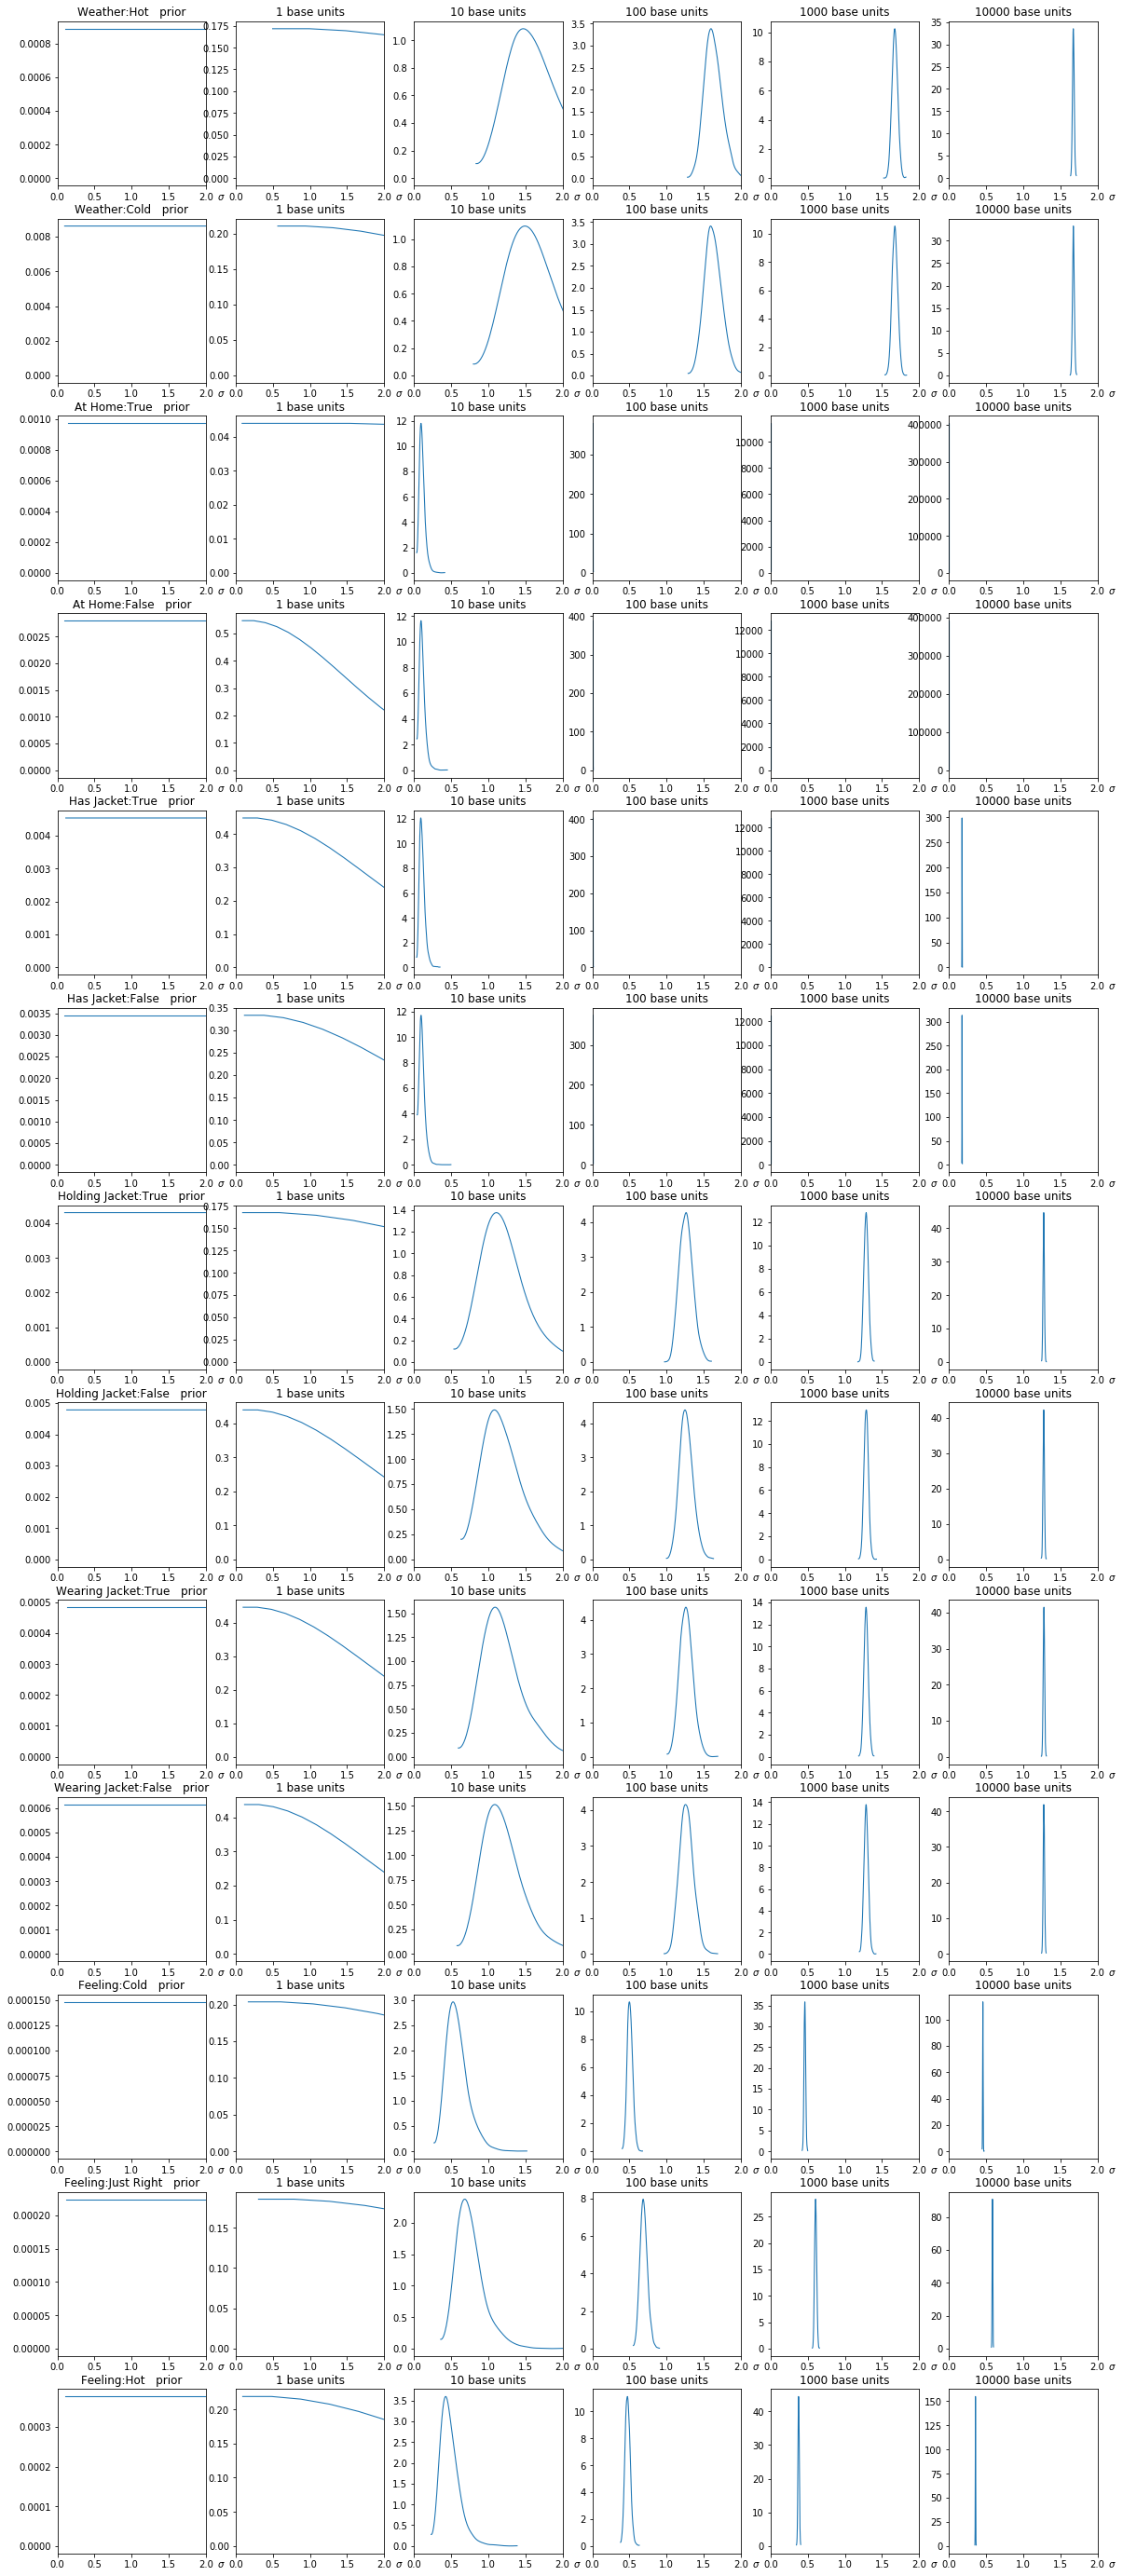

In [4]:
plt.figure(figsize=(15,130))
prior_sample = sigma.random(size=4000)
for i in range(state_feature_matrix.shape[1]+action_feature_matrix.shape[1]):
    for j in range(len(n_base_list)+1):
        plt.subplot(state_feature_matrix.shape[1]+action_feature_matrix.shape[1], 
                    len(n_base_list)+1, i*(len(n_base_list)+1)+j+1)
        data = prior_sample[:,i] if j==0 else trace_list[j-1]['sigma'][:,i]
        ax = pm.plots.kdeplot(data, textsize=10)
        ax.set_xlim(0, 1)
        if j==0:
            if i<state_feature_matrix.shape[1]:
                ax.set_title(environment.state_feature_names[i])
            else:
                ax.set_title(environment.action_feature_names[i-state_feature_matrix.shape[1]])
        else:
            ax.set_title('{} base units'.format(n_base_list[j-1]))
        ax.set_xlabel('$\\sigma$', labelpad=-10, x=1.1)

### theta correlation plot

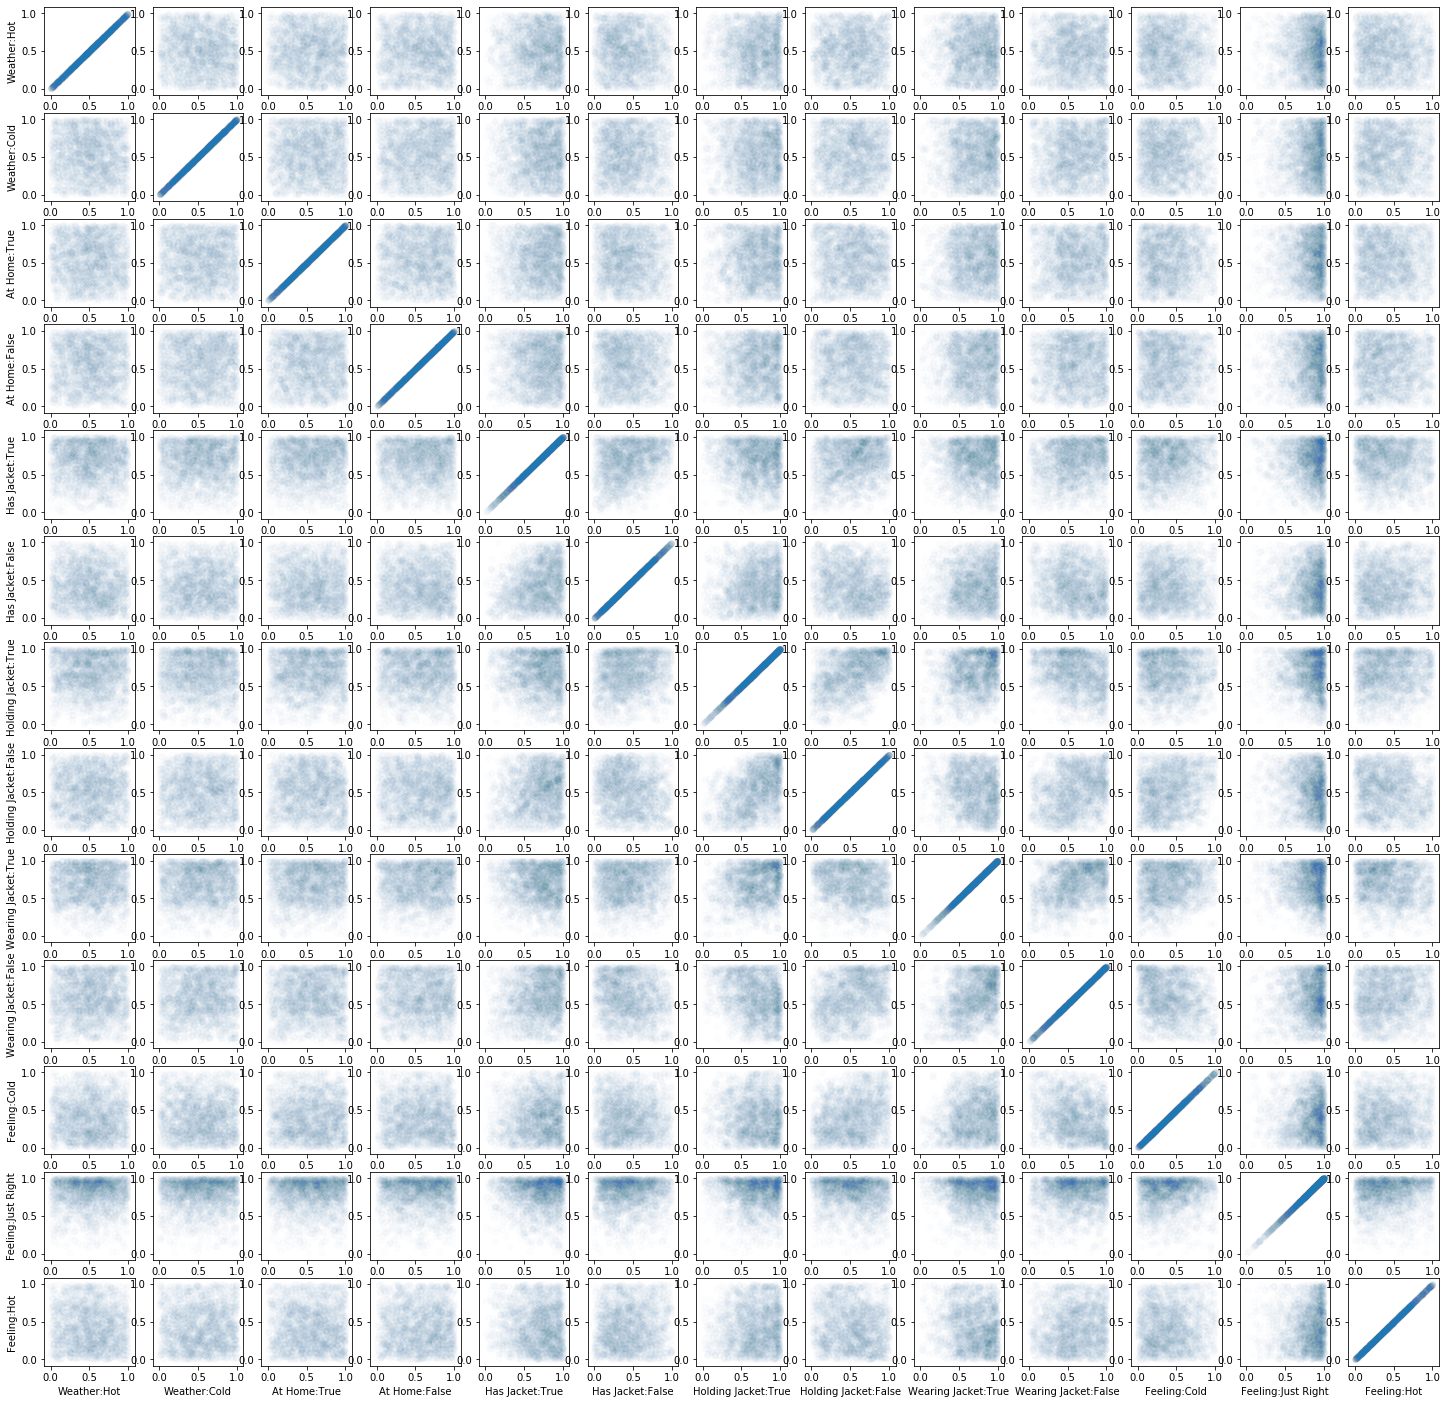

In [5]:
plt.figure(figsize=(25,25))

for i in range(state_feature_matrix.shape[1]+action_feature_matrix.shape[1]):
    for j in range(state_feature_matrix.shape[1]+action_feature_matrix.shape[1]):
        plt.subplot(state_feature_matrix.shape[1]+action_feature_matrix.shape[1]
                    ,state_feature_matrix.shape[1]+action_feature_matrix.shape[1]
                    ,i*(state_feature_matrix.shape[1]+action_feature_matrix.shape[1])+j+1)
        plt.scatter(trace_list[0]['theta'][:2000,j],trace_list[0]['theta'][:2000,i], alpha=0.01)
        if j==0:
            if i<state_feature_matrix.shape[1]:
                plt.ylabel(environment.state_feature_names[i])
            else:
                plt.ylabel(environment.action_feature_names[i-state_feature_matrix.shape[1]])
        if i==feature_matrix.shape[1]-1:
            if i<state_feature_matrix.shape[1]:
                plt.xlabel(environment.state_feature_names[j])
            else:
                plt.xlabel(environment.action_feature_names[j-state_feature_matrix.shape[1]])